In [2]:
import pandas as pd
import numpy as np
import re

SEED = 42

In [3]:
df = pd.read_csv('../data/ELLIPSE_Full_manual_clean_finished_calculated.csv')

df.head(2)

,text_id,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,task,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions
0,2021000501,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Male,8,Hispanic/Latino,111,122,118,7,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,3.5,2.5,3.5,3.0,3.5,2.5
1,2021000535,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Female,8,Hispanic/Latino,99,105,102,6,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,4.0,3.5,3.0,3.5


## Prompts


<Axes: >

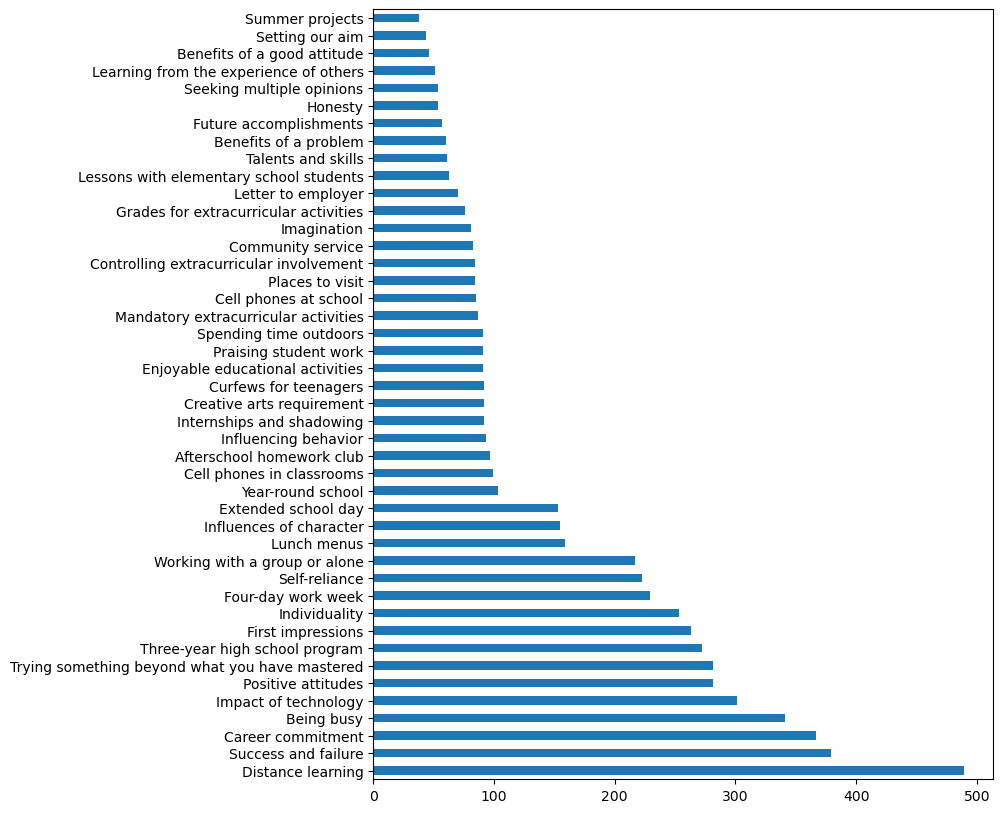

In [4]:
df.prompt.value_counts().plot.barh(figsize=(8,10))

# We have some long texts
Most transformers have a maximum sequence length of 512 tokens. We are going to go ahead and use Longformer, even though that will make it challenging to interpret later down the road :(

<Axes: ylabel='Frequency'>

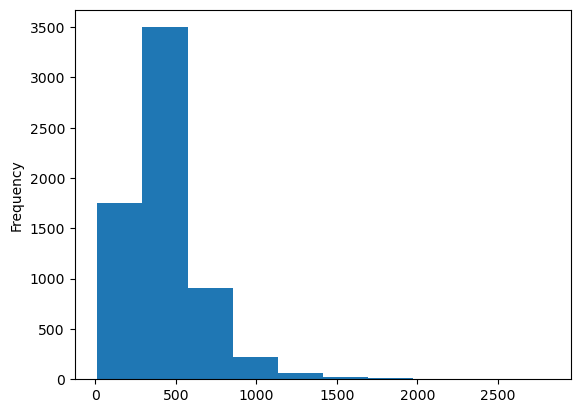

In [5]:
df.num_words.plot.hist()

## Clean text

Collapse all contiguous spans of whitespace into a single space. Also removes leading and trailing whitespace.

In [6]:
df['clean_text'] = df.full_text.apply(lambda text: re.sub(r'\s+', r' ', text.strip()))
df.clean_text.sample(5)

2928    Have you ever wondered why teachers encourage ...
20      Policy 1: I think policy one is better that we...
1738    is setting a good example by your own behavior...
4734    Author Ralph Waldo wrote, " To be yourself in ...
3631    Some people are not agree with the Summer brea...
Name: clean_text, dtype: object

## Setup Transformers and Datasets


In [9]:
from transformers import LongformerTokenizer

from datasets import Dataset, DatasetDict

In [8]:
model_name = 'allenai/longformer-base-4096'

tokenizer = LongformerTokenizer.from_pretrained(model_name)

def tokenize_inputs(example):
    return tokenizer(example['text'],
                     max_length=4096,
                     return_attention_mask=True,
                     return_token_type_ids=True,
                     truncation=True)

## Build Dataset

In [13]:
def build_dataset(df):
    
    columns = ['text_id',
               'clean_text',
               'Overall',
               'Cohesion',
               'Syntax',
               'Vocabulary',
               'Phraseology',
               'Grammar',
               'Conventions']
    
    subset = df[columns].rename(columns = {'clean_text': 'text'})
    
    ds = Dataset.from_pandas(subset,
                             preserve_index=False)
    
    # 70% train, 15% development, 15% test
    train_test = ds.train_test_split(test_size=0.3, seed=SEED)
    train = train_test['train']
    _remains = train_test['test']
    
    dev_test = _remains.train_test_split(test_size=0.5, seed=SEED)
    dev = dev_test['train']
    test = dev_test['test']
    
    dd = DatasetDict({
        'train': train,
        'dev': dev, 
        'test': test})
    
    dd = dd.map(tokenize_inputs,
                batched=True,
                remove_columns=['text'])
    
    return dd

In [14]:
dd = build_dataset(df)

Map:   0%|          | 0/4537 [00:00<?, ? examples/s]

Map:   0%|          | 0/972 [00:00<?, ? examples/s]

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

In [15]:
dd.save_to_disk('../data/ellipse.hf')

Saving the dataset (0/1 shards):   0%|          | 0/4537 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/972 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/973 [00:00<?, ? examples/s]